## Predicting Bike Rentals


## The Case
Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which you'll be working with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the **[University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)**. If you need help at any point, you can consult the solution notebook in our GitHub repository.

## Goal
Predict the total number of bikes people rented in a given hour. To accomplish this, I'll create a few different machine learning models, evaluate their performance and identify an optimal model for predicting bike the number of hourly rentals.

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

bike_rentals = pd.read_csv("bike_rental_hour.csv")
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


I'll predict the `cnt` column using all of the other columns, except for `casual` and `registered`.

(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

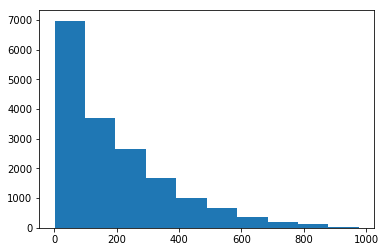

In [28]:
%matplotlib inline
plt.hist(bike_rentals["cnt"])

In [29]:
bike_rentals.corr()["cnt"]

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

The **`hr`** column in **`bike_rentals`** contains the hours during which bikes are rented, from **`1`** to **`24`**. A machine will treat each hour differently, without understanding that certain hours are related. I can introduce some order into the process by creating a new column with labels for **`morning`**, **`afternoon`**, **`evening`**, and **`night`**. This will bundle similar times together, enabling the model to make better decisions.

I received a letter in the mail saying they needed to verify my ID in person, but I don't live in the state. I need to know what I should do. Thanks.

In [30]:
def assign_label(hr):
    if hr in range(6, 12):
        return 1
    elif hr in range(12,18):
        return 2
    elif hr in range(18,24):
        return 3
    elif hr in range(0,6):
        return 4
    
bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)    

## Evaluating the error
The mean squared error (MSE) is the best error evaluation technique as it works on continuous numeric data, which fits my data quite well.

Splitting the data into training and testing sets. 

In [31]:
train = bike_rentals.sample(frac=0.8)

In [32]:
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

Linear regression works best when predictors are linearly correlated to the target and also independent -- in other words, they don't change meaning when I combine them with each other. The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward. It also can be prone to underfitting the data, however, and not building a powerful enough model. This means that linear regression usually isn't the most accurate option, but but it's worth giving a go here.

I will ignore the **`casual`** and **`registered`** columns because **`cnt`** is derived from them. Since I'm trying to predict the number of people who rent bikes in a given hour (**`cnt`**), it doesn't make sense that I'd already know **`casual`** or **`registered`**, because those numbers are added together to get **`cnt`**.

Creating a list of predictor columns to use in training and predictions.

In [33]:
from sklearn.linear_model import LinearRegression

predictors = list(train.columns)
predictors.remove('cnt')
predictors.remove('casual')
predictors.remove('registered')
predictors.remove('dteday')

reg = LinearRegression()

reg.fit(train[predictors], train['cnt'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [34]:
import numpy
predictions = reg.predict(test[predictors])

numpy.mean((predictions - test["cnt"]) ** 2)

16794.793229918396

Ouch! The error is super high, which could be the result of the data having few extremely high rental counts and the rest being mostly low counts. It should be noted larger errors are penalized greater with MSE which in turn leads to a higher total error.

Now I'm ready to apply the decision tree algorithm. I'll be able to compare its error with the error from linear regression, which will enable me to pick the right algorithm for this data set.

Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when I don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [35]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(min_samples_leaf=5)

reg.fit(train[predictors], train["cnt"])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [36]:
predictions = reg.predict(test[predictors])

numpy.mean((predictions - test["cnt"]) ** 2)

2594.8616447756986

In [37]:
reg = DecisionTreeRegressor(min_samples_leaf=2)

reg.fit(train[predictors], train["cnt"])

predictions = reg.predict(test[predictors])

numpy.mean((predictions - test["cnt"]) ** 2)

2824.1906485743493

## Comparing Decision tree vs. Random forest error

I can now apply the random forest algorithm, which improves on the decision tree algorithm. Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. But still, random forests can still be prone to overfitting so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [38]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(min_samples_leaf=5)
reg.fit(train[predictors], train["cnt"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [39]:
predictions = reg.predict(test[predictors])

numpy.mean((predictions - test["cnt"]) ** 2)

2041.3419434154205

## Conclusion
By removing some of the sources of overfitting, the **`random forest`** accuracy exceeds the decision tree accuracy in this case and is therefore the better choice for predicting bike rentals per hour.